# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data, and compares its performance directly to the Dueling-Thompson sampling acquisition function by Gonzalez et al (2017). 

We conduct experiments over simple 1-dimensional values in the domain [0, 1] and define the following preference ordering over them: given the Forrester function f (1-dimensional test function by Forrester et al. (2008)), and two inputs a and b, a > b if f(a) < f(b).

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 2 levels up directory to import PBO
import PBO

In [2]:
def forrester(x):
    """
    1-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    :param x: float in domain [0, 1]
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)

def forrester_get_y(X):
    """
    Returns np array of shape (num_data, 1), indicating the input value with the most preferred Forrester value
    (lower is better)
    param X: np array of shape (num_data, num_choices, 1)
    """
    
    forr_vals = np.argmin(forrester(X), axis=1)
    return np.squeeze(np.take_along_axis(X, np.expand_dims(forr_vals, axis=2), axis=1), axis=2)

Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

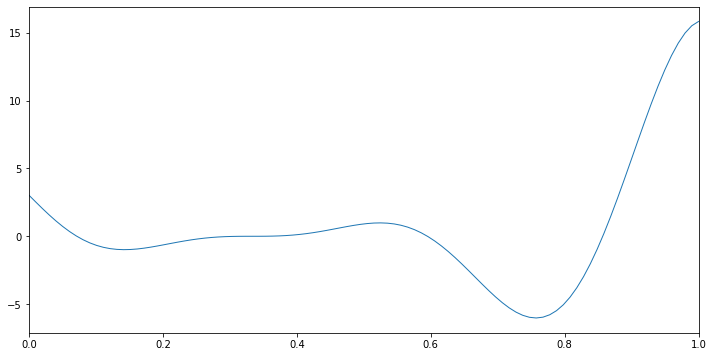

In [3]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, forrester(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [4]:
def plot_gp(model, X, y, title):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

## 1.  Learning from ordinal data

In [5]:
# Sample data
X = np.array([[[0.2], [0.4]],
              [[0.4], [0.7]],
              [[0.76], [0.9]],
              [[0.9], [0.2]],
              [[0.7], [0.9]],
              [[0.2], [0.7]],
              [[0.7], [0.76]]])
y = forrester_get_y(X)

In [6]:
q_mu, q_sqrt, u, inputs, k = PBO.models.learning.train_model_fullcov(X, y, num_inducing=5, num_steps=2000)

Negative ELBO at step 0: 6.218796776111869
Negative ELBO at step 500: 4.807194056386403
Negative ELBO at step 1000: 4.731157320956029
Negative ELBO at step 1500: 4.723301569105331


In [7]:
q_mu

<tf.Variable 'q_mu:0' shape=(5, 1) dtype=float64, numpy=
array([[ 0.40647354],
       [ 0.2060199 ],
       [-0.78753159],
       [ 0.58933419],
       [-0.51444757]])>

In [8]:
print_summary(k)

Create sparse variational Gaussian process model using these parameters:

In [9]:
# kernel = gpflow.kernels.RBF()
likelihood = gpflow.likelihoods.Gaussian()
model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)

In [10]:
print_summary(model)

Visualize the model so far:

In [11]:
u_mean = q_mu.numpy()
inducing_vars = u.numpy()

In [12]:
inducing_vars

array([[0.17426311],
       [0.2547856 ],
       [0.39214609],
       [0.79874667],
       [0.84489661]])

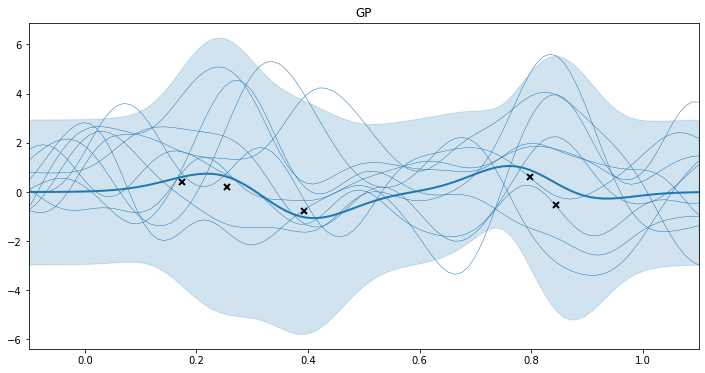

In [13]:
plot_gp(model, inducing_vars, u_mean, "GP")

## 2. Predictive Entropy Search

In [14]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 5
num_inducing_init = 5
num_discrete_points = 10000 # Discretization of continuous input space

The following function captures what was done in the previous section, as we need to retrain the model after every evaluation.

In [15]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k = PBO.models.learning.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         num_steps=2000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [16]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = np.linspace(0.0, 1.0, num_discrete_points).reshape(num_discrete_points, 1)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [17]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [18]:
np.random.seed(0)
init_points = np.random.uniform(size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

Beginning run 0
Negative ELBO at step 0: 8.57265105584233
Negative ELBO at step 500: 7.736259574279366
Negative ELBO at step 1000: 7.440725196347216
Negative ELBO at step 1500: 7.322965804192108
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: 1.2308840410687978
Loss at step 500: -9.925389062504337
Loss at step 1000: -15.629021514367839
Loss at step 1500: -18.68784217169317
Loss at step 2000: -19.270608221800707
Loss at step 2500: -19.554748136883013
tf.Tensor(
[[0.88516759]
 [0.01897888]
 [0.79768785]
 [0.40783425]
 [0.75831608]
 [0.28091913]
 [0.81223304]
 [0.84089156]
 [0.71967094]
 [0.64603977]
 [0.94985875]
 [0.6646806 ]
 [0.79509635]
 [0.66621831]
 [0.95338403]
 [0.04047866]
 [0.65178856]
 [0.5959984 ]
 [0.38834725]
 [0.23209664]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.71518937]
 [0.94437239]], shape=(2, 1), dtype=float64) with I value of 0.15350899488788755
Evaluation 0: Training model
Negativ

Evaluation 7: Next query is tf.Tensor(
[[0.60276338]
 [0.87355683]], shape=(2, 1), dtype=float64) with I value of 0.2470234989955419
Evaluation 7: Training model
Negative ELBO at step 0: 16.148488770882906
Negative ELBO at step 500: 11.726187570444523
Negative ELBO at step 1000: 11.083852867568895
Negative ELBO at step 1500: 10.902684347692492
Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: 0.03766632916530854
Loss at step 500: -5.7194089531890855
Loss at step 1000: -8.582277332090634
Loss at step 1500: -9.399395380021991
Loss at step 2000: -9.634971576928852
Loss at step 2500: -9.731997004748486
tf.Tensor(
[[0.38772653]
 [0.27933762]
 [0.64264136]
 [0.12870668]
 [0.21259537]
 [0.99095238]
 [0.23803985]
 [0.77154258]
 [0.66672679]
 [0.32622543]
 [0.85617556]
 [0.2856693 ]
 [0.20759093]
 [0.36164245]
 [0.30976047]
 [0.78947926]
 [0.60933001]
 [0.59387763]
 [0.08650481]
 [0.96533888]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next q

Beginning evaluation 16
Evaluation 16: Sampling maximizers
Loss at step 0: 1.664626390758483
Loss at step 500: -2.9031131593478374
Loss at step 1000: -4.997078257804277
Loss at step 1500: -5.405542715352297
Loss at step 2000: -5.515175117205247
Loss at step 2500: -5.559621127910931
tf.Tensor(
[[0.90220909]
 [0.749746  ]
 [0.12720606]
 [0.08530462]
 [0.225239  ]
 [0.48977939]
 [0.65905723]
 [0.84362752]
 [0.61249465]
 [0.70754283]
 [0.2100219 ]
 [0.16049418]
 [0.33604053]
 [0.47052783]
 [0.57537001]
 [0.74905287]
 [0.29132316]
 [0.90063864]
 [0.65681164]
 [0.31717597]], shape=(20, 1), dtype=float64)
Evaluation 16: Calculating I
Evaluation 16: Next query is tf.Tensor(
[[0.31673067]
 [0.07260007]], shape=(2, 1), dtype=float64) with I value of 0.25238139299266554
Evaluation 16: Training model
Negative ELBO at step 0: 74.60261925991908
Negative ELBO at step 500: 18.890704832211963
Negative ELBO at step 1000: 17.317721844078584
Negative ELBO at step 1500: 17.08219241686086
Beginning evaluati

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 1
Negative ELBO at step 0: 8.848850362338098
Negative ELBO at step 500: 7.255038380509501
Negative ELBO at step 1000: 6.826746683065662
Negative ELBO at step 1500: 6.73109957629718


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -6.899761553506047
Loss at step 500: -14.081055108293627
Loss at step 1000: -19.70432670076802
Loss at step 1500: -22.461062566259148
Loss at step 2000: -23.620874666492742
Loss at step 2500: -24.19169882040829
tf.Tensor(
[[0.2157576 ]
 [0.30854959]
 [0.49441147]
 [0.34877262]
 [0.49409671]
 [0.20271171]
 [0.3808805 ]
 [0.48351906]
 [0.4365974 ]
 [0.0733505 ]
 [0.02168092]
 [0.06849151]
 [0.05059073]
 [0.56536612]
 [0.67061553]
 [0.05231984]
 [0.23545762]
 [0.84013122]
 [0.0947423 ]
 [0.2890664 ]], shape=(20, 1), dtype=float64)
Evaluation 0: Calculating I
Evaluation 0: Next query is tf.Tensor(
[[0.64589411]
 [0.42669141]], shape=(2, 1), dtype=float64) with I value of 0.29768933865252906
Evaluation 0: Training model
Negative ELBO at step 0: 9.749495133869782
Negative ELBO at step 500: 8.09506653190742
Negative ELBO at step 1000: 7.705556130217379
Negative ELBO at step 1500: 7.58541726055957


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: -7.837674875699376
Loss at step 500: -14.977639542968356
Loss at step 1000: -19.947629759425894
Loss at step 1500: -21.710065959012834
Loss at step 2000: -22.460899312380853
Loss at step 2500: -22.857207303735365
tf.Tensor(
[[0.62739476]
 [0.04820223]
 [0.59268247]
 [0.24756692]
 [0.67573389]
 [0.44257168]
 [0.57408496]
 [0.80218152]
 [0.44200634]
 [0.75316529]
 [0.5867006 ]
 [0.10417146]
 [0.4352564 ]
 [0.45056176]
 [0.53140977]
 [0.33902156]
 [0.40010202]
 [0.5762203 ]
 [0.16366355]
 [0.48552749]], shape=(20, 1), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.64589411]
 [0.33965102]], shape=(2, 1), dtype=float64) with I value of 0.34226722181451535
Evaluation 1: Training model
Negative ELBO at step 0: 10.651213747636877
Negative ELBO at step 500: 9.324395532080008
Negative ELBO at step 1000: 8.934347185706796
Negative ELBO at step 1500: 8.782102406138176


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: 1.7347866595219086
Loss at step 500: -11.731584903918527
Loss at step 1000: -14.925566849491247
Loss at step 1500: -15.843996901902033
Loss at step 2000: -16.019100347189745
Loss at step 2500: -16.11717269735811
tf.Tensor(
[[0.65800757]
 [0.68325919]
 [0.10560391]
 [0.62601855]
 [0.5277647 ]
 [0.88072116]
 [0.11202116]
 [0.05505232]
 [0.34289611]
 [0.18022217]
 [0.98486633]
 [0.72309315]
 [0.69550331]
 [0.49503516]
 [0.56790637]
 [0.32040805]
 [0.11493339]
 [0.55110137]
 [0.39252965]
 [0.63301871]], shape=(20, 1), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[0.64589411]
 [0.38163932]], shape=(2, 1), dtype=float64) with I value of 0.16294835824148868
Evaluation 2: Training model
Negative ELBO at step 0: 11.553858417870728
Negative ELBO at step 500: 7.689805256388804
Negative ELBO at step 1000: 7.135686762760097
Negative ELBO at step 1500: 7.137461547481863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: 1.5342090107659079
Loss at step 500: -2.4637973018348194
Loss at step 1000: -6.263537040591097
Loss at step 1500: -8.195217536027963
Loss at step 2000: -8.986064365151964
Loss at step 2500: -9.346966347086834
tf.Tensor(
[[0.30690737]
 [0.35880331]
 [0.46051465]
 [0.5308791 ]
 [0.06895191]
 [0.54588948]
 [0.91019747]
 [0.22621335]
 [0.67474524]
 [0.7549749 ]
 [0.54376078]
 [0.58612481]
 [0.07857038]
 [0.30041263]
 [0.97518948]
 [0.78029805]
 [0.80494553]
 [0.42418259]
 [0.50433771]
 [0.53542257]], shape=(20, 1), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[0.42669141]
 [0.8309088 ]], shape=(2, 1), dtype=float64) with I value of 0.2865482404537377
Evaluation 3: Training model
Negative ELBO at step 0: 12.456453934875242
Negative ELBO at step 500: 10.469648641306039
Negative ELBO at step 1000: 10.190995453084525
Negative ELBO at step 1500: 10.09752587943649


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -5.825251486585293
Loss at step 500: -13.384784574103307
Loss at step 1000: -15.559354165472373
Loss at step 1500: -15.7632697161282
Loss at step 2000: -15.78222533836876
Loss at step 2500: -15.786886220650032
tf.Tensor(
[[0.62569967]
 [0.54587528]
 [0.66725269]
 [0.66640751]
 [0.23993862]
 [0.54028298]
 [0.19359915]
 [0.75107345]
 [0.4527992 ]
 [0.30565541]
 [0.59750098]
 [0.69691336]
 [0.06972201]
 [0.75751303]
 [0.60180098]
 [0.56038924]
 [0.19673742]
 [0.47569433]
 [0.6563294 ]
 [0.76036401]], shape=(20, 1), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.43758721]
 [0.66218365]], shape=(2, 1), dtype=float64) with I value of 0.17958863615892856
Evaluation 4: Training model
Negative ELBO at step 0: 13.365809749627106
Negative ELBO at step 500: 11.194826427573481
Negative ELBO at step 1000: 10.909729337707912
Negative ELBO at step 1500: 10.77721423685252


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: 3.0195156649339507
Loss at step 500: -8.802207560441971
Loss at step 1000: -13.072615626221705
Loss at step 1500: -13.818451733855445
Loss at step 2000: -13.94964127776613
Loss at step 2500: -13.995350856601167
tf.Tensor(
[[0.6631369 ]
 [0.61869925]
 [0.09948842]
 [0.69936237]
 [0.60259305]
 [0.43730065]
 [0.70532086]
 [0.62556018]
 [0.23080146]
 [0.55170891]
 [0.5559704 ]
 [0.0526366 ]
 [0.59681853]
 [0.81163103]
 [0.67477404]
 [0.54540013]
 [0.43021357]
 [0.69662426]
 [0.09489177]
 [0.71963406]], shape=(20, 1), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.66218365]
 [0.0922796 ]], shape=(2, 1), dtype=float64) with I value of 0.16280087922892644
Evaluation 5: Training model
Negative ELBO at step 0: 14.258375296932906
Negative ELBO at step 500: 11.074248452616523
Negative ELBO at step 1000: 10.651460012700058
Negative ELBO at step 1500: 10.510715302385172


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: -4.302973190847856
Loss at step 500: -11.95617794569262
Loss at step 1000: -14.106171113984296
Loss at step 1500: -14.484983031795906
Loss at step 2000: -14.598708966381585
Loss at step 2500: -14.654709532331808
tf.Tensor(
[[0.36292744]
 [0.05934598]
 [0.64494321]
 [0.99201411]
 [0.19714719]
 [0.52877266]
 [0.35390157]
 [0.56296296]
 [0.70189232]
 [0.66031076]
 [0.07034645]
 [0.83378739]
 [0.73643091]
 [0.435412  ]
 [0.67127367]
 [0.67518224]
 [0.77140601]
 [0.05757663]
 [0.50779891]
 [0.58324055]], shape=(20, 1), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[0.64589411]
 [0.28058998]], shape=(2, 1), dtype=float64) with I value of 0.21460756957474014
Evaluation 6: Training model
Negative ELBO at step 0: 15.310080938184555
Negative ELBO at step 500: 11.91119011337176
Negative ELBO at step 1000: 11.403187624296564
Negative ELBO at step 1500: 11.22096681877681


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: -3.0184066757635106
Loss at step 500: -9.802008061249882
Loss at step 1000: -12.47965096263069
Loss at step 1500: -13.107986711401045
Loss at step 2000: -13.331639630474566
Loss at step 2500: -13.454090186504434
tf.Tensor(
[[0.70891562]
 [0.10164424]
 [0.68586457]
 [0.64214515]
 [0.91898546]
 [0.6581062 ]
 [0.65005181]
 [0.63306718]
 [0.72416114]
 [0.50810448]
 [0.01390698]
 [0.01500421]
 [0.43465252]
 [0.65858159]
 [0.15595184]
 [0.67082356]
 [0.57783087]
 [0.5704947 ]
 [0.26504664]
 [0.70540233]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.64589411]
 [0.00505187]], shape=(2, 1), dtype=float64) with I value of 0.17335028570193342
Evaluation 7: Training model
Negative ELBO at step 0: 16.359903610647667
Negative ELBO at step 500: 11.431351390903167
Negative ELBO at step 1000: 10.323251278577999
Negative ELBO at step 1500: 10.00084715707904


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: 2.135470960594171
Loss at step 500: -2.094890277680972
Loss at step 1000: -5.875172299895016
Loss at step 1500: -6.9733420619155035
Loss at step 2000: -7.217556127263585
Loss at step 2500: -7.315224758864273
tf.Tensor(
[[0.82679319]
 [0.98850937]
 [0.44077008]
 [0.33068363]
 [0.34284003]
 [0.5956537 ]
 [0.5921302 ]
 [0.49689826]
 [0.59131413]
 [0.56122483]
 [0.4499253 ]
 [0.33169072]
 [0.3431302 ]
 [0.72250508]
 [0.53089518]
 [0.30832639]
 [0.62329703]
 [0.0715595 ]
 [0.70450029]
 [0.97689383]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.42669141]
 [0.80489403]], shape=(2, 1), dtype=float64) with I value of 0.3701320462670066
Evaluation 8: Training model
Negative ELBO at step 0: 17.59708695076843
Negative ELBO at step 500: 12.123649792046889
Negative ELBO at step 1000: 11.484912976775279
Negative ELBO at step 1500: 11.284587085245915


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: 1.8146182152022368
Loss at step 500: -2.513745236904719
Loss at step 1000: -5.416725658950453
Loss at step 1500: -6.099688466643278
Loss at step 2000: -6.279078146575759
Loss at step 2500: -6.368835003555076
tf.Tensor(
[[0.7179575 ]
 [0.14972427]
 [0.59959012]
 [0.40180362]
 [0.71712282]
 [0.87845248]
 [0.55028475]
 [0.59086859]
 [0.44134187]
 [0.5313581 ]
 [0.4939758 ]
 [0.03656464]
 [0.84141986]
 [0.60784235]
 [0.63826239]
 [0.66383619]
 [0.39222306]
 [0.65465205]
 [0.02329273]
 [0.71931282]], shape=(20, 1), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.42669141]
 [0.15578562]], shape=(2, 1), dtype=float64) with I value of 0.30672066247042884
Evaluation 9: Training model
Negative ELBO at step 0: 19.35086484090409
Negative ELBO at step 500: 12.950411280087774
Negative ELBO at step 1000: 12.254077593507105
Negative ELBO at step 1500: 12.087170240369217


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: 1.4955396296470724
Loss at step 500: -4.35277934761708
Loss at step 1000: -7.720093702248841
Loss at step 1500: -8.731238076066754
Loss at step 2000: -9.016591737973945
Loss at step 2500: -9.256737953446368
tf.Tensor(
[[0.08780594]
 [0.24767612]
 [0.64377121]
 [0.72619955]
 [0.67963658]
 [0.07770618]
 [0.31666705]
 [0.70759153]
 [0.72996057]
 [0.76365572]
 [0.16956376]
 [0.93389945]
 [0.1495098 ]
 [0.71835691]
 [0.3581687 ]
 [0.69192556]
 [0.71055585]
 [0.21796919]
 [0.29742287]
 [0.42610773]], shape=(20, 1), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.80489403]
 [0.16121821]], shape=(2, 1), dtype=float64) with I value of 0.26811755989213915
Evaluation 10: Training model
Negative ELBO at step 0: 21.288305813401916
Negative ELBO at step 500: 13.457018264454554
Negative ELBO at step 1000: 12.76547834696026
Negative ELBO at step 1500: 12.585352760995377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Evaluation 11: Sampling maximizers
Loss at step 0: -1.100063678032717
Loss at step 500: -5.538996154501094
Loss at step 1000: -7.52213620580069
Loss at step 1500: -8.031184649352939
Loss at step 2000: -8.103959966328276
Loss at step 2500: -8.133847256395088
tf.Tensor(
[[0.19218999]
 [0.58226652]
 [0.65493557]
 [0.42000435]
 [0.35579697]
 [0.59684445]
 [0.52293984]
 [0.56770927]
 [0.66689557]
 [0.98867683]
 [0.62891943]
 [0.63695909]
 [0.233957  ]
 [0.88551858]
 [0.65575156]
 [0.74565704]
 [0.19560716]
 [0.70124116]
 [0.20003192]
 [0.63745317]], shape=(20, 1), dtype=float64)
Evaluation 11: Calculating I
Evaluation 11: Next query is tf.Tensor(
[[0.16121821]
 [0.75249141]], shape=(2, 1), dtype=float64) with I value of 0.29628411558494877
Evaluation 11: Training model
Negative ELBO at step 0: 24.176136517788986
Negative ELBO at step 500: 14.22358448374792
Negative ELBO at step 1000: 13.23878946094173
Negative ELBO at step 1500: 12.989643306849088


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Evaluation 12: Sampling maximizers
Loss at step 0: -0.9274279725464389
Loss at step 500: -8.365344184283142
Loss at step 1000: -11.711176921332582
Loss at step 1500: -12.468925553591959
Loss at step 2000: -12.639579221795419
Loss at step 2500: -12.706111013947897
tf.Tensor(
[[0.06712625]
 [0.31288417]
 [0.72535929]
 [0.42772592]
 [0.60889697]
 [0.7549697 ]
 [0.61425468]
 [0.70411322]
 [0.22205452]
 [0.70877911]
 [0.76793483]
 [0.56372969]
 [0.75202987]
 [0.76563441]
 [0.05985245]
 [0.70334939]
 [0.60085537]
 [0.29290288]
 [0.92235619]
 [0.09881518]], shape=(20, 1), dtype=float64)
Evaluation 12: Calculating I
Evaluation 12: Next query is tf.Tensor(
[[0.0922796 ]
 [0.83258852]], shape=(2, 1), dtype=float64) with I value of 0.2570115316500636
Evaluation 12: Training model
Negative ELBO at step 0: 28.02162108129849
Negative ELBO at step 500: 14.556440242790583
Negative ELBO at step 1000: 13.538150723349093
Negative ELBO at step 1500: 13.305027916572467


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Evaluation 13: Sampling maximizers
Loss at step 0: -1.4842507760255392
Loss at step 500: -7.296183524373429
Loss at step 1000: -10.42265303377444
Loss at step 1500: -10.877560451594753
Loss at step 2000: -10.98468280602787
Loss at step 2500: -11.040586734601032
tf.Tensor(
[[0.52719274]
 [0.59103372]
 [0.36938159]
 [0.67167568]
 [0.62148348]
 [0.57324716]
 [0.86298966]
 [0.02595507]
 [0.69868514]
 [0.48899205]
 [0.60370322]
 [0.06346886]
 [0.81260018]
 [0.23823622]
 [0.7163702 ]
 [0.77167789]
 [0.69210545]
 [0.69398475]
 [0.90115812]
 [0.62755406]], shape=(20, 1), dtype=float64)
Evaluation 13: Calculating I
Evaluation 13: Next query is tf.Tensor(
[[0.33965102]
 [0.78172309]], shape=(2, 1), dtype=float64) with I value of 0.21861565644511693
Evaluation 13: Training model
Negative ELBO at step 0: 33.68721122802282
Negative ELBO at step 500: 15.421262801348968
Negative ELBO at step 1000: 14.067757540132263
Negative ELBO at step 1500: 13.768401989476338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Evaluation 14: Sampling maximizers
Loss at step 0: 4.022359445162728
Loss at step 500: -4.3708787810078364
Loss at step 1000: -9.212807872427174
Loss at step 1500: -10.121948771125377
Loss at step 2000: -10.259364639166748
Loss at step 2500: -10.280912269675628
tf.Tensor(
[[0.62018775]
 [0.50235187]
 [0.65429048]
 [0.65537681]
 [0.36344823]
 [0.79554202]
 [0.72620335]
 [0.47414378]
 [0.63411399]
 [0.76764649]
 [0.56370342]
 [0.8535683 ]
 [0.72074824]
 [0.45729109]
 [0.28222984]
 [0.72745989]
 [0.62117848]
 [0.42099718]
 [0.65137284]
 [0.16269728]], shape=(20, 1), dtype=float64)
Evaluation 14: Calculating I
Evaluation 14: Next query is tf.Tensor(
[[0.80489403]
 [0.21370719]], shape=(2, 1), dtype=float64) with I value of 0.3139158523550487
Evaluation 14: Training model
Negative ELBO at step 0: 42.01925109747538
Negative ELBO at step 500: 15.61043240134342
Negative ELBO at step 1000: 14.267716112604749
Negative ELBO at step 1500: 13.996739498326788


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Evaluation 15: Sampling maximizers
Loss at step 0: 0.12170013045133521
Loss at step 500: -4.841179184609358
Loss at step 1000: -6.863928999725991
Loss at step 1500: -7.327887509484678
Loss at step 2000: -7.478111784084831
Loss at step 2500: -7.568517326017093
tf.Tensor(
[[0.00926503]
 [0.71464583]
 [0.64390884]
 [0.53402934]
 [0.6611637 ]
 [0.65211565]
 [0.76356306]
 [0.92328469]
 [0.63994618]
 [0.51076292]
 [0.66394527]
 [0.06331816]
 [0.54288849]
 [0.90072563]
 [0.70143997]
 [0.70428523]
 [0.41457275]
 [0.6558028 ]
 [0.95785265]
 [0.0387742 ]], shape=(20, 1), dtype=float64)
Evaluation 15: Calculating I
Evaluation 15: Next query is tf.Tensor(
[[0.891773  ]
 [0.47902151]], shape=(2, 1), dtype=float64) with I value of 0.24298641096444853
Evaluation 15: Training model
Negative ELBO at step 0: 54.805541293927305
Negative ELBO at step 500: 16.317786633643298
Negative ELBO at step 1000: 14.904822961226948
Negative ELBO at step 1500: 14.625939885573166


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Evaluation 16: Sampling maximizers
Loss at step 0: 0.9258536822591559
Loss at step 500: -4.343626280350625
Loss at step 1000: -7.309217224247606
Loss at step 1500: -7.992511882853324
Loss at step 2000: -8.463172573484737
Loss at step 2500: -8.651655342578039
tf.Tensor(
[[0.71080967]
 [0.74905315]
 [0.67572268]
 [0.57425355]
 [0.6736736 ]
 [0.7577341 ]
 [0.66355251]
 [0.59669778]
 [0.69377558]
 [0.03882003]
 [0.56729457]
 [0.59337876]
 [0.27463113]
 [0.64404293]
 [0.54095182]
 [0.48160353]
 [0.65484648]
 [0.01776134]
 [0.60594133]
 [0.68884516]], shape=(20, 1), dtype=float64)
Evaluation 16: Calculating I
Evaluation 16: Next query is tf.Tensor(
[[0.38344152]
 [0.33568778]], shape=(2, 1), dtype=float64) with I value of 0.1700243133902542
Evaluation 16: Training model
Negative ELBO at step 0: 74.90113286479416
Negative ELBO at step 500: 17.359577724241632
Negative ELBO at step 1000: 15.678840067291468
Negative ELBO at step 1500: 15.357593213230697


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Evaluation 17: Sampling maximizers
Loss at step 0: -0.4394113180108954
Loss at step 500: -6.0987522873816635
Loss at step 1000: -9.65016059095459
Loss at step 1500: -10.639405829491034
Loss at step 2000: -10.94269162344596
Loss at step 2500: -11.04136473459286
tf.Tensor(
[[0.55175137]
 [0.53489842]
 [0.72305301]
 [0.63543317]
 [0.73060462]
 [0.75328645]
 [0.67457156]
 [0.75646657]
 [0.65202588]
 [0.9318157 ]
 [0.71472127]
 [0.0279214 ]
 [0.09819707]
 [0.67993312]
 [0.74769733]
 [0.77052047]
 [0.46012639]
 [0.62797324]
 [0.92289867]
 [0.63933932]], shape=(20, 1), dtype=float64)
Evaluation 17: Calculating I
Evaluation 17: Next query is tf.Tensor(
[[0.47902151]
 [0.29591214]], shape=(2, 1), dtype=float64) with I value of 0.18779157023055942
Evaluation 17: Training model
Negative ELBO at step 0: 106.97694151648537
Negative ELBO at step 500: 18.72486692089233
Negative ELBO at step 1000: 16.47381305674381
Negative ELBO at step 1500: 16.03166370892258


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Evaluation 18: Sampling maximizers
Loss at step 0: 2.7875525188036097
Loss at step 500: -5.075005680185268
Loss at step 1000: -9.432630420978917
Loss at step 1500: -10.236781994268913
Loss at step 2000: -10.374488345066096
Loss at step 2500: -10.410179354966338
tf.Tensor(
[[0.81458687]
 [0.72545491]
 [0.80693519]
 [0.63769039]
 [0.49927652]
 [0.55143072]
 [0.6779629 ]
 [0.48213257]
 [0.16138972]
 [0.54474481]
 [0.69943441]
 [0.36607989]
 [0.81950069]
 [0.03167297]
 [0.29419201]
 [0.53905254]
 [0.56446033]
 [0.62926502]
 [0.66724825]
 [0.64543424]], shape=(20, 1), dtype=float64)
Evaluation 18: Calculating I
Evaluation 18: Next query is tf.Tensor(
[[0.15578562]
 [0.31599016]], shape=(2, 1), dtype=float64) with I value of 0.20572405138187722
Evaluation 18: Training model
Negative ELBO at step 0: 160.01255460294718
Negative ELBO at step 500: 20.406597046481664


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



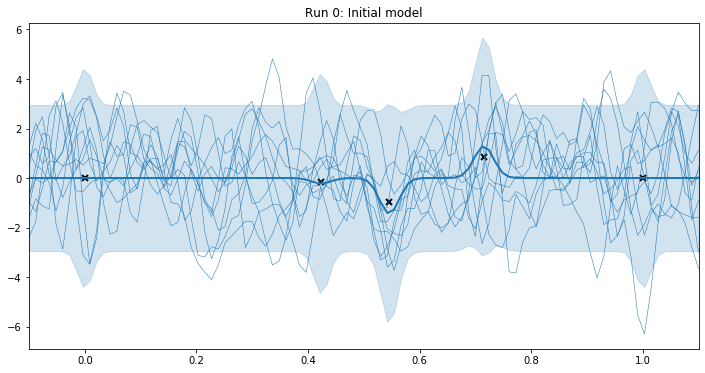

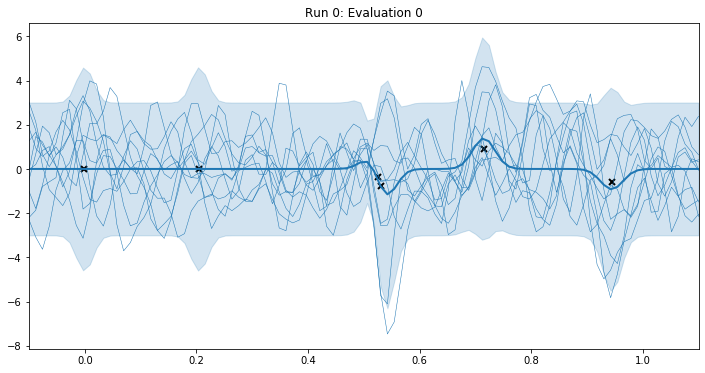

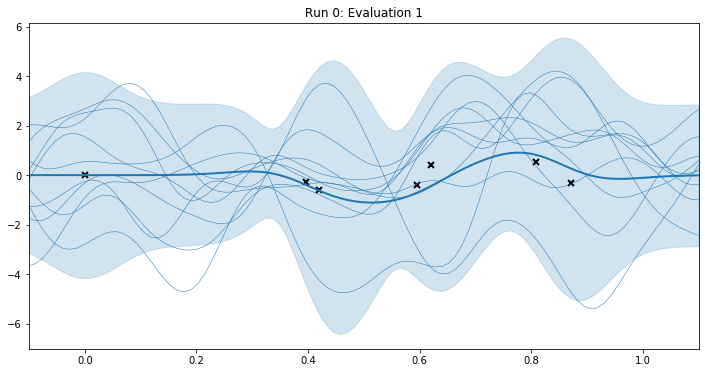

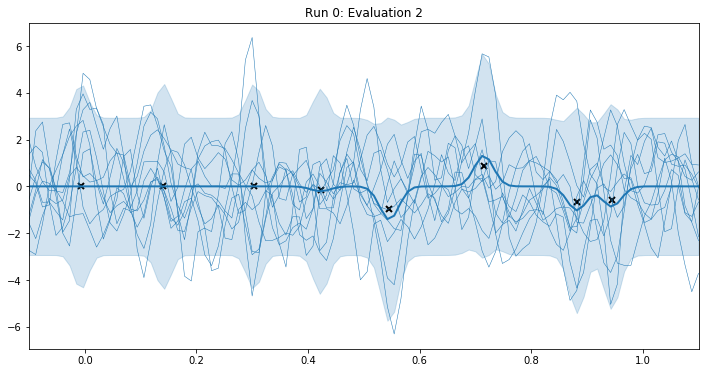

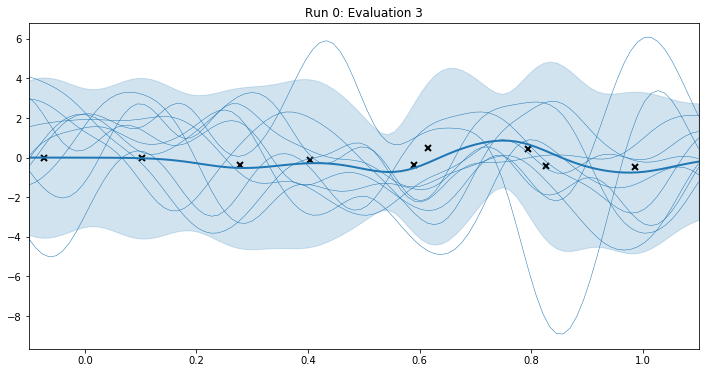

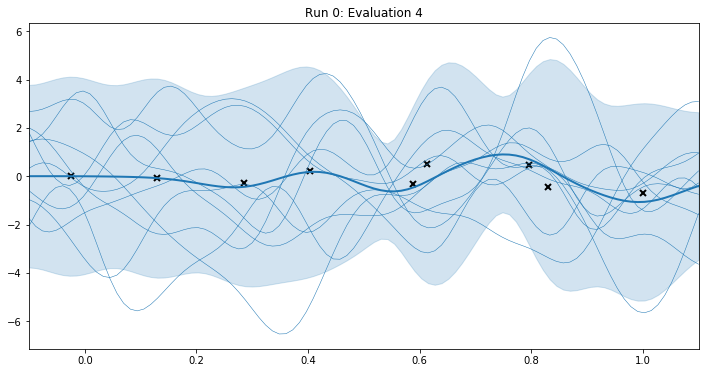

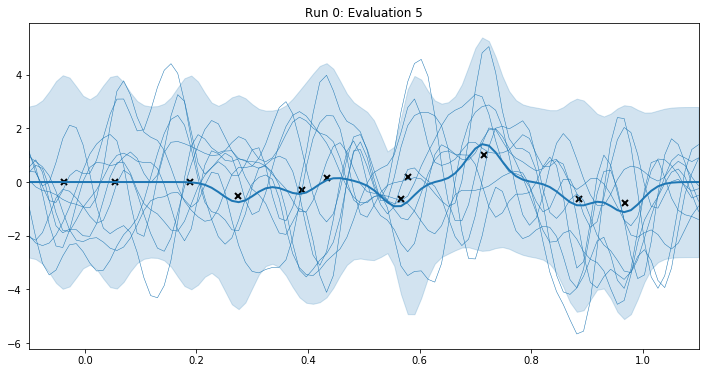

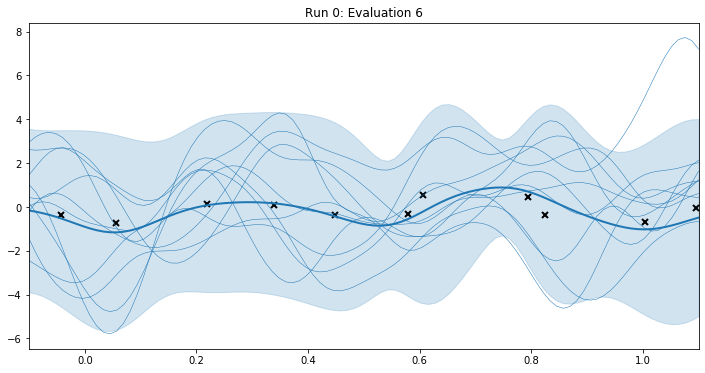

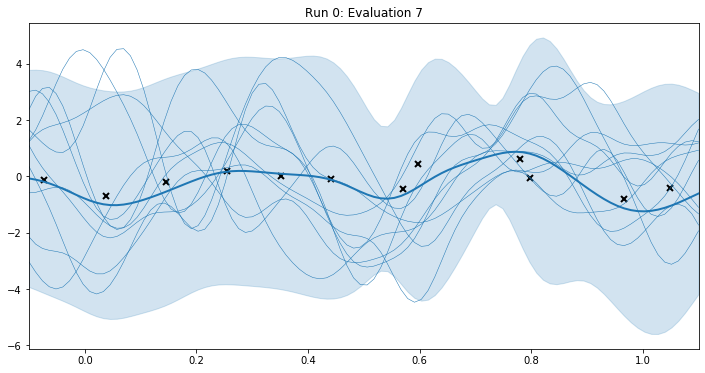

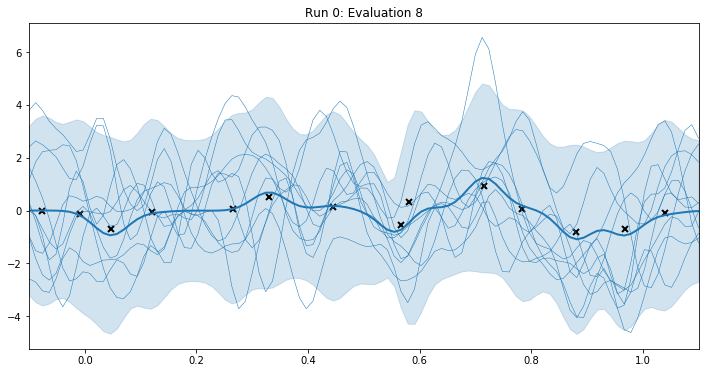

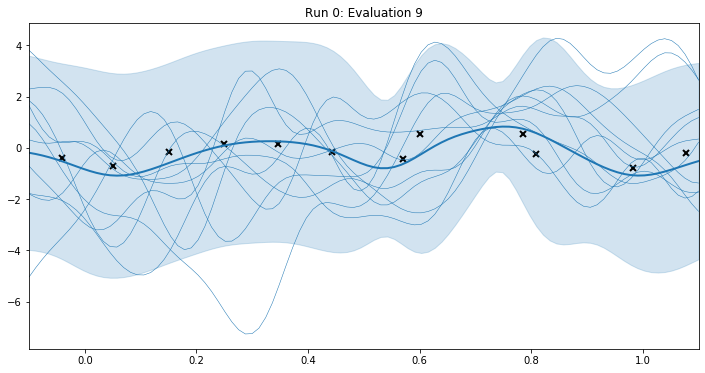

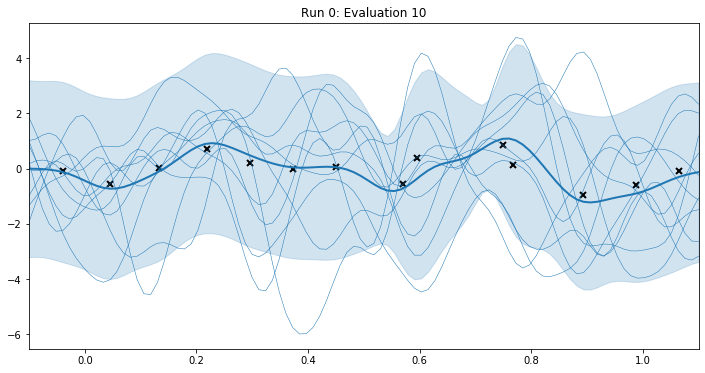

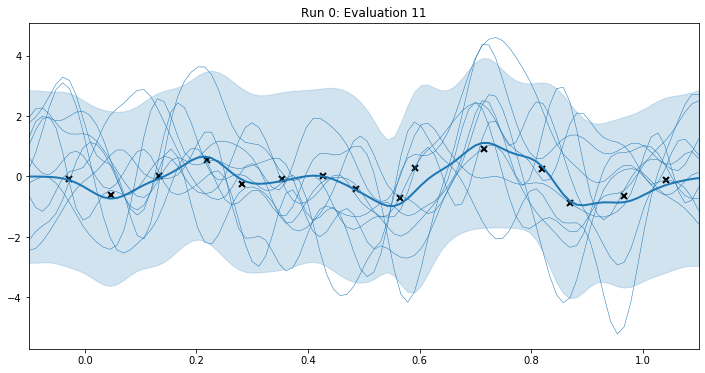

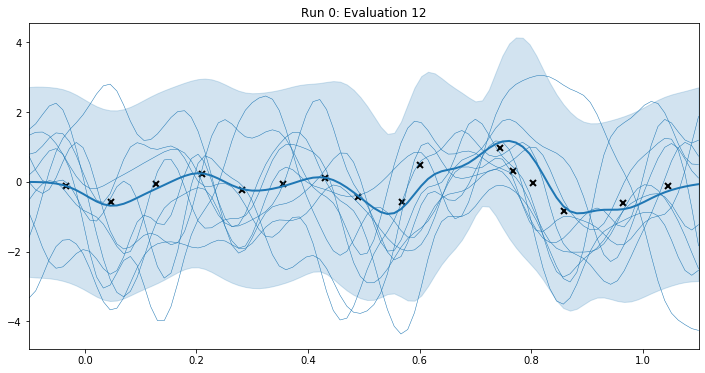

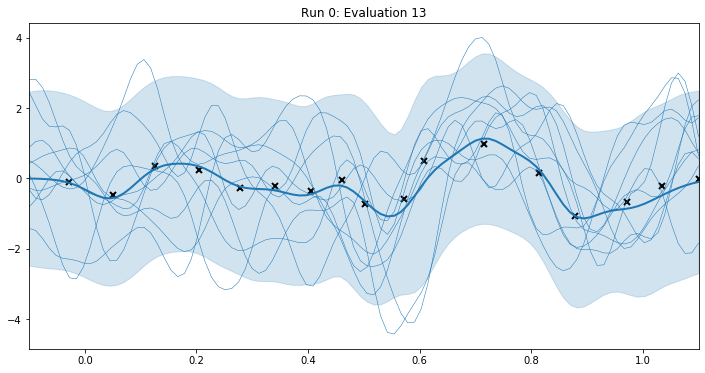

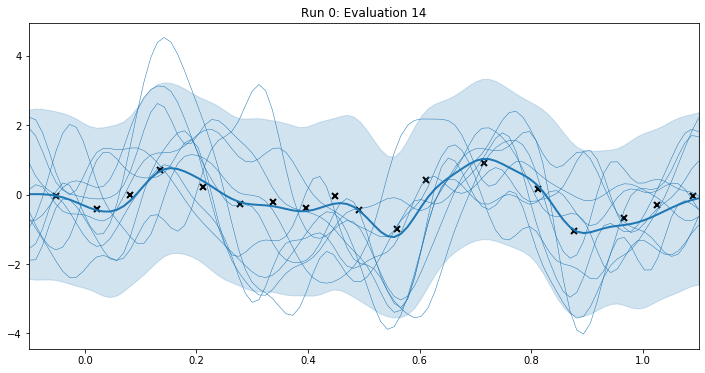

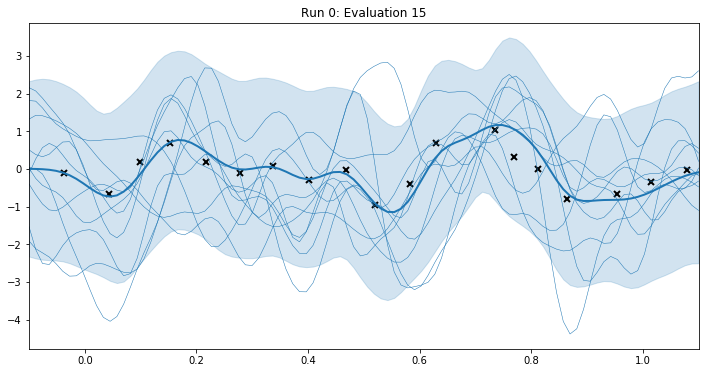

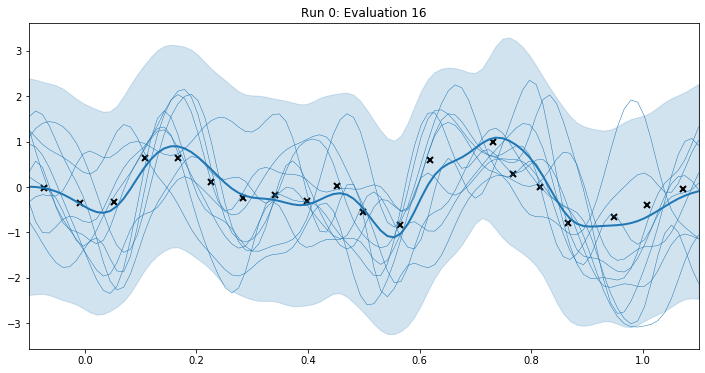

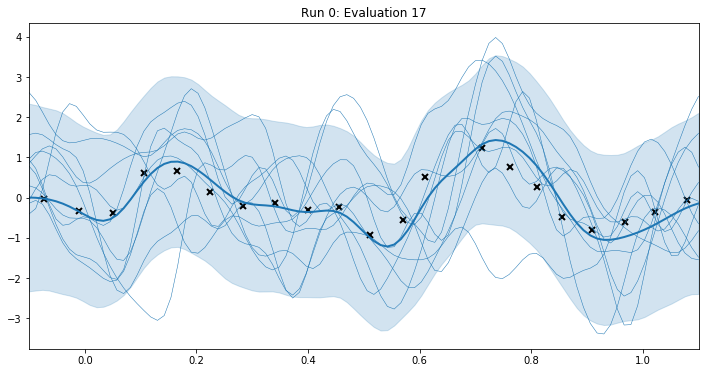

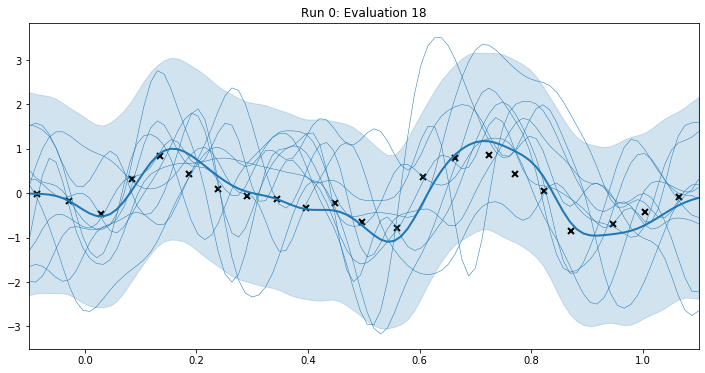

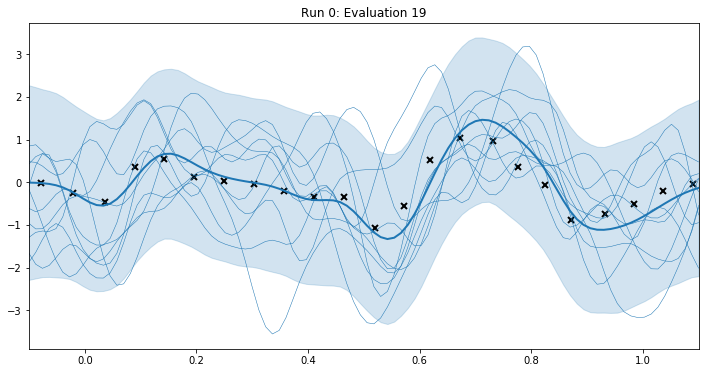

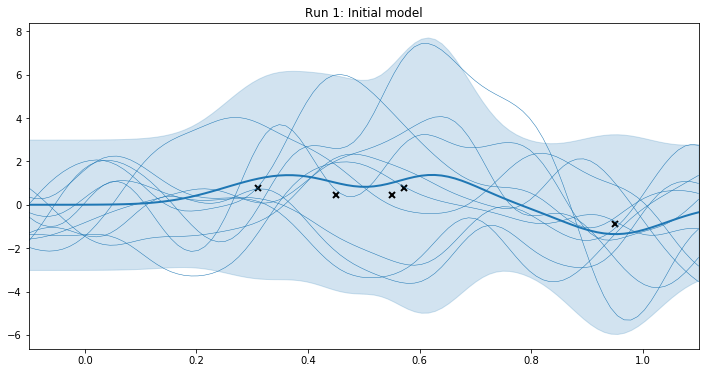

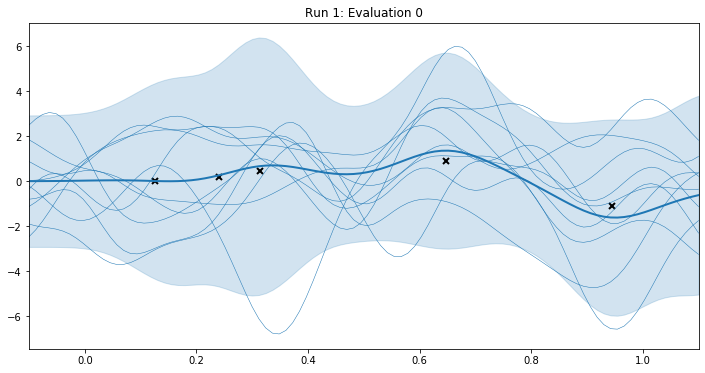

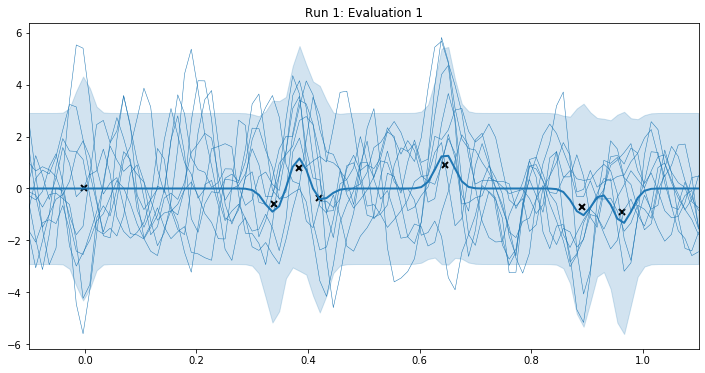

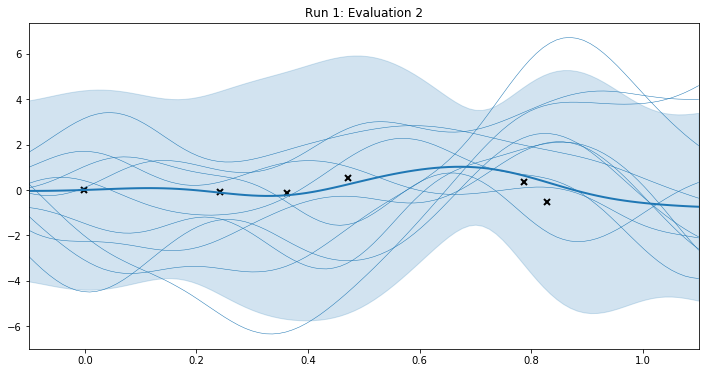

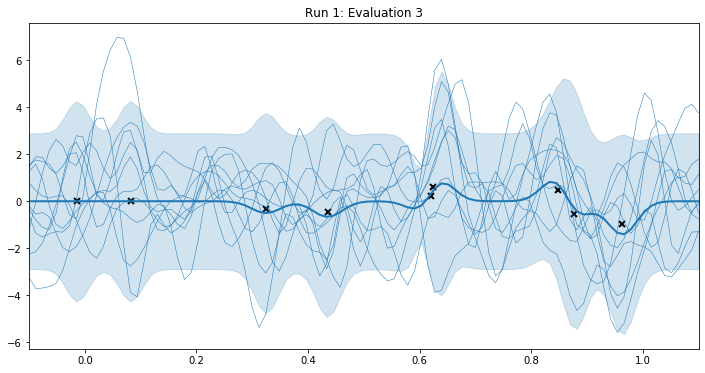

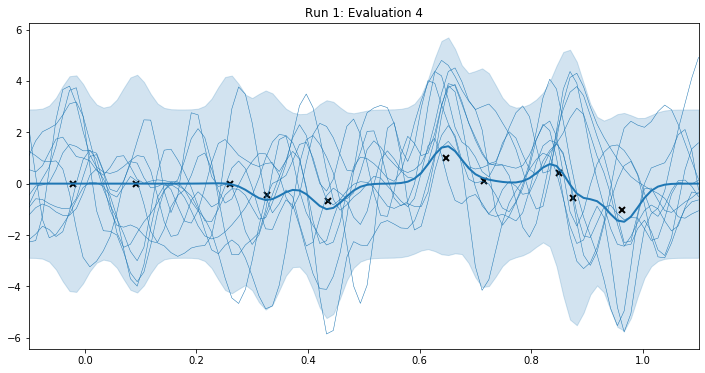

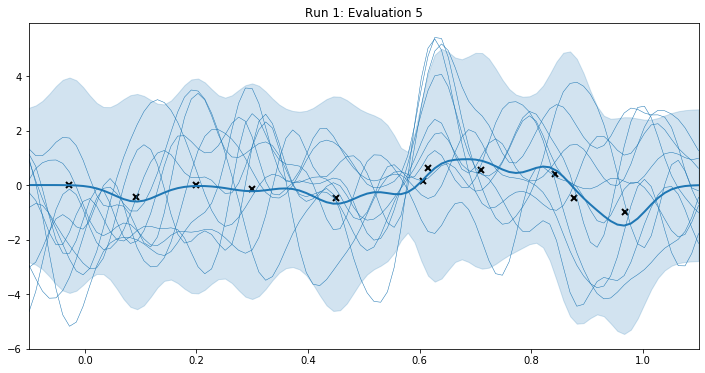

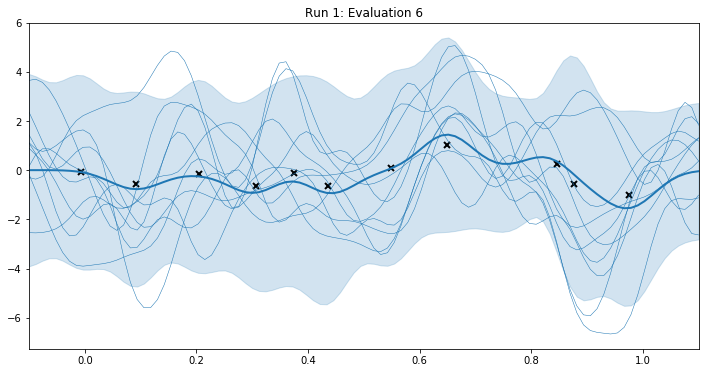

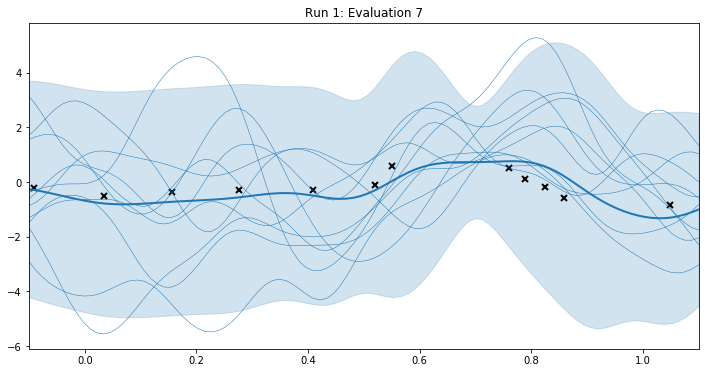

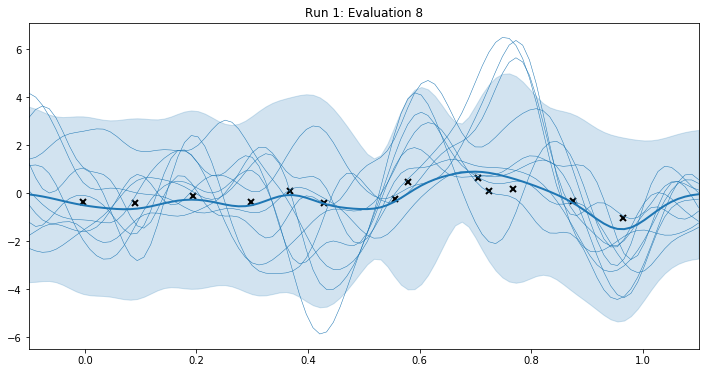

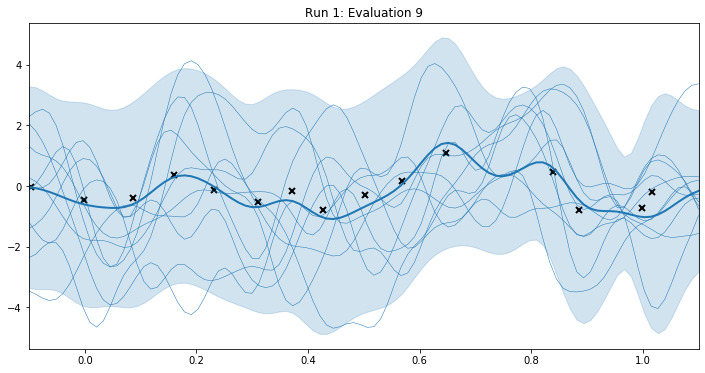

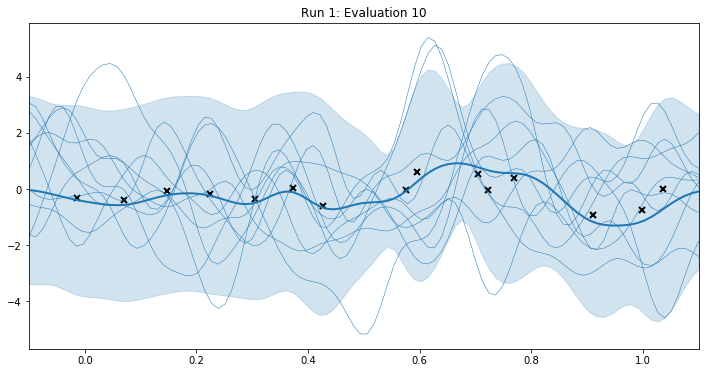

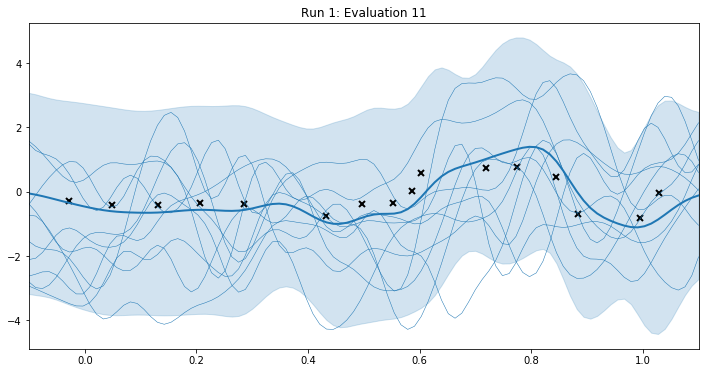

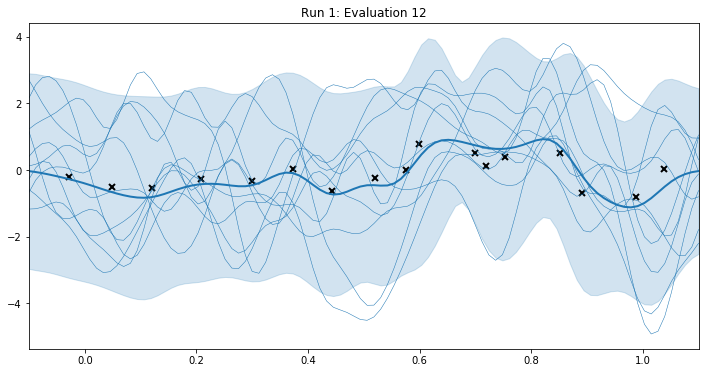

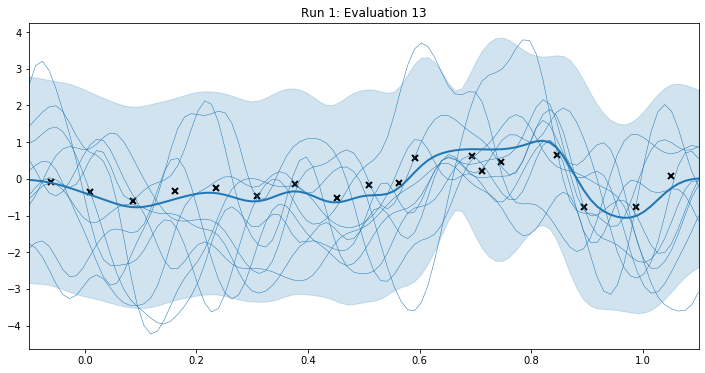

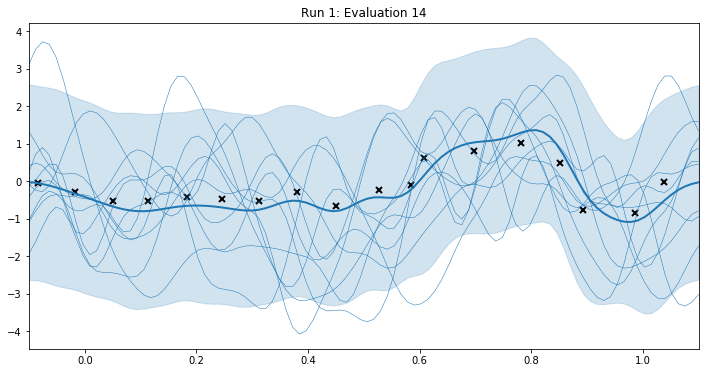

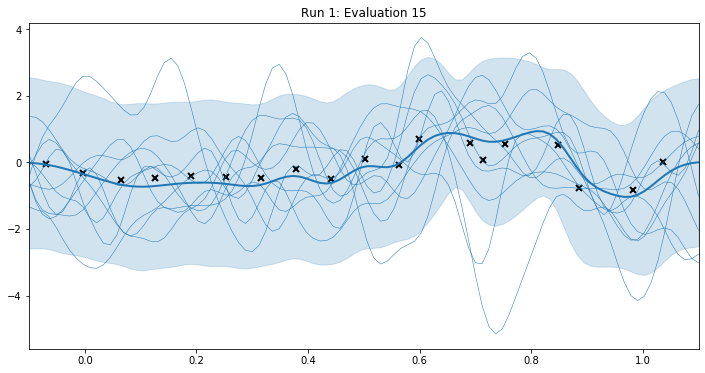

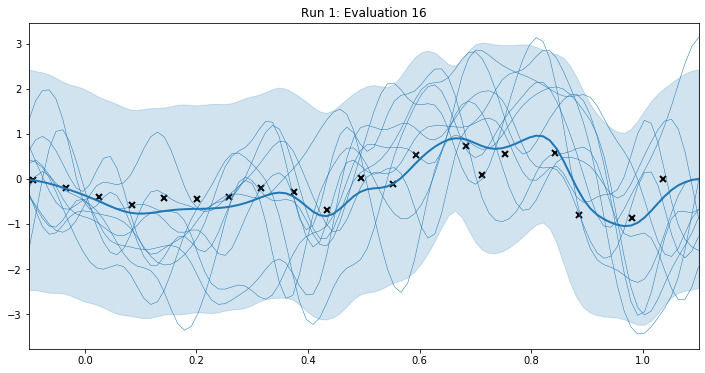

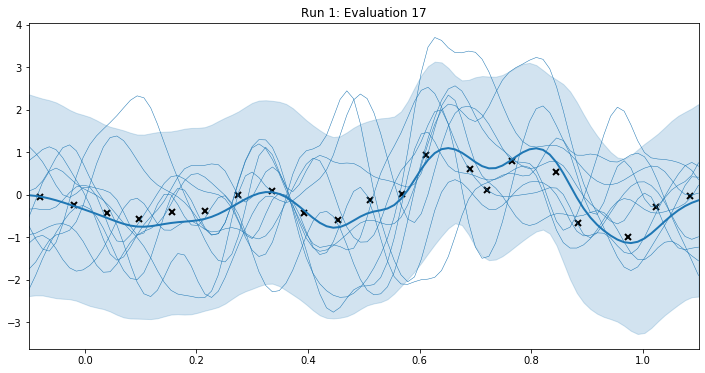

In [19]:
for run in range(num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = forrester_get_y(X)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run {}: Initial model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        
        samples = PBO.acquisitions.pes.sample_inputs(inputs, num_samples, num_choices)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.acquisitions.pes.sample_maximizers(X=inducing_vars,
                                                            y=u_mean,
                                                            count=num_maximizers,
                                                            D=100,
                                                            model=model)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = forrester_get_y(X)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run {}: Evaluation {}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

In [ ]:
xx = np.linspace(0.0, 1.0, num_discrete_points).reshape(num_discrete_points, 1)
global_min = xx[np.argmin(forrester(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = abs(best_guess_results[i] - global_min)
    
    x_axis = list(range(11, 31))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess error', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()